In [17]:
import pandas as pd 

data = pd.read_csv("data/counts_normalized_log2_shortlabels.csv") 

# Hacemos que la columna de Gene_Name sea el índice del DataFrame
data.set_index("Gene_Name", inplace=True)

data

,ARN_DHT_R1,ARN_DHT_R2,BIC_DHT_R1,BIC_DHT_R2,CTL_DHT_R1,CTL_DHT_R2,ENZ_DHT_R1,ENZ_DHT_R2
Gene_Name,,,,,,,,
A1BG,8.744624,7.910898,8.120633,7.754471,7.813781,8.044341,8.912943,7.910619
A1BG-AS1,8.866078,8.585575,8.686505,8.472798,8.588715,8.322901,8.886718,8.616526
A1CF,5.273291,4.907101,4.640495,5.133134,3.000000,3.331796,5.159085,4.971521
A2M,4.344827,3.723817,2.582046,3.983977,3.459432,4.114662,3.717614,3.614688
A2M-AS1,6.179589,6.154233,5.777922,6.202302,5.727920,5.838587,5.706739,5.999977
...,...,...,...,...,...,...,...,...
ZYG11A,6.833167,6.602474,6.581498,6.172963,6.303781,6.010789,6.290488,6.560310
ZYG11B,10.219262,11.092731,10.653820,11.024912,10.710806,10.895888,10.053771,10.912960
ZYX,11.478077,10.957510,11.194331,10.741136,11.661333,11.003043,11.418783,10.958529


In [18]:
topK  = 10

# Lectura de las importantes para la prediccion de cada droga 
important_genes_ARN = pd.read_csv("results/RandomForestDE/imp_ARN.csv")["Gene_Name"].values[:topK]
important_genes_BIC = pd.read_csv("results/RandomForestDE/imp_BIC.csv")["Gene_Name"].values[:topK]
important_genes_ENZ = pd.read_csv("results/RandomForestDE/imp_ENZ.csv")["Gene_Name"].values[:topK]

# Nos quedamos con los genes importantes
important_genes = set(important_genes_ARN).union(set(important_genes_BIC)).union(set(important_genes_ENZ))

# Seleccionamos solo esos genes en el DataFrame
data = data.loc[data.index.intersection(important_genes)]

In [19]:
# Quitamos la columna de CTL_DHT_R1 y CTL_DHT_R2 de data 
data = data.drop(columns=["CTL_DHT_R1", "CTL_DHT_R2"])

In [21]:
# Promediamos la columna de ARN_DHT_R1 y ARN_DHT_R2 para generar una sola 
data["ARN_DHT"] = data[["ARN_DHT_R1", "ARN_DHT_R2"]].mean(axis=1)
data = data.drop(columns=["ARN_DHT_R1", "ARN_DHT_R2"])
data["BIC_DHT"] = data[["BIC_DHT_R1", "BIC_DHT_R2"]].mean(axis=1)
data = data.drop(columns=["BIC_DHT_R1", "BIC_DHT_R2"])
data["ENZ_DHT"] = data[["ENZ_DHT_R1", "ENZ_DHT_R2"]].mean(axis=1)
data = data.drop(columns=["ENZ_DHT_R1", "ENZ_DHT_R2"])

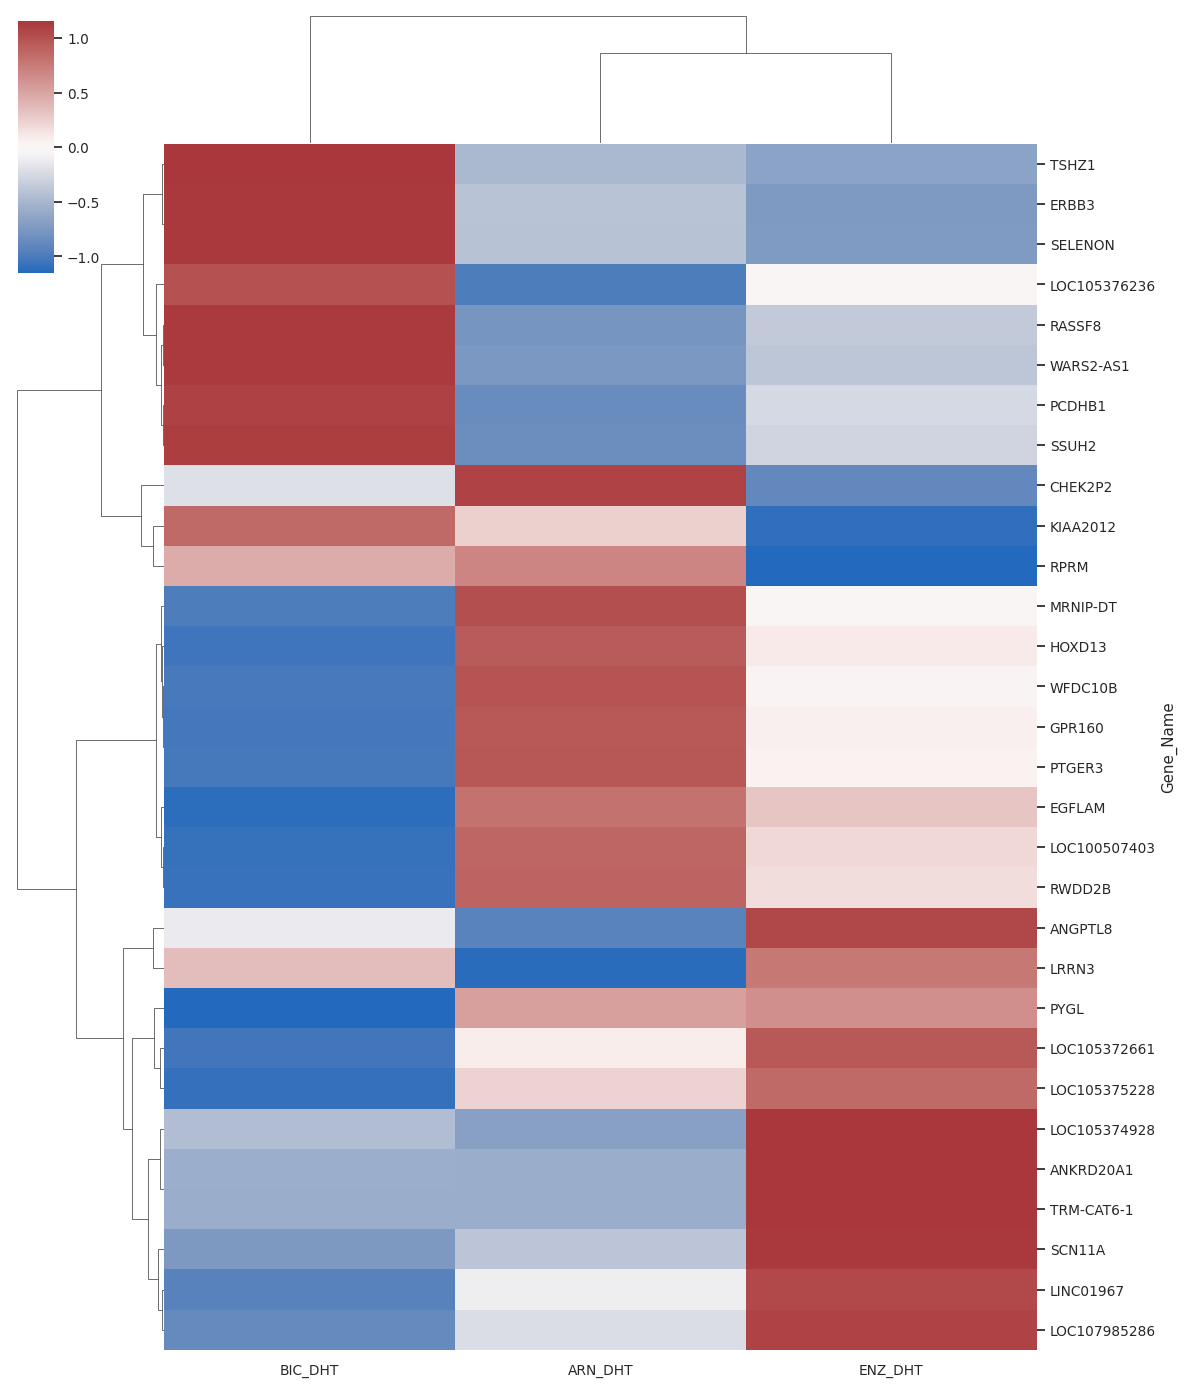

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram


# Convertir a matriz numérica
expr = data.apply(pd.to_numeric, errors='coerce')

# -------------------------------------------------
# 2. Z-score por gen (muy recomendado)
# -------------------------------------------------
# Esto estandariza cada gen: mean=0, std=1
expr_z = expr.subtract(expr.mean(axis=1), axis=0)
expr_z = expr_z.divide(expr.std(axis=1), axis=0)

# -------------------------------------------------
# 3. Clustering jerárquico (método Ward)
# -------------------------------------------------
row_linkage = linkage(expr_z, method='ward', metric='euclidean')
col_linkage = linkage(expr_z.T, method='ward', metric='euclidean')

# -------------------------------------------------
# 4. Graficar el cluster heatmap
# -------------------------------------------------
sns.set(font_scale=0.9)

g = sns.clustermap(
    expr_z,
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    cmap="vlag",          # bueno para datos centrados en 0
    figsize=(12, 14),
    xticklabels=True,
    yticklabels=True,  
    linewidths=0,
    dendrogram_ratio=(0.15, 0.1),
    cbar_pos=(0.02, 0.8, 0.03, 0.18)
)

plt.show()